# Quantum Kitchen Sinks algorithm for regression

## Global imports

In [1]:
import time, sys
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVR, SVR

# Qiskit
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import QuantumCircuit, ParameterVector

# sys.path.append('/Users/nabok/Work/Notebooks/qml/git/quantum-kitchen-sinks')
from qks.QuantumKitchenSinks import QuantumKitchenSinks
from qks.ProjectedQuantumKitchenSinks import ProjectedQuantumKitchenSinks


seed = 12345
np.random.seed(seed)

plt.style.use('classic')
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 16

In [2]:
def compute_score(y_true, y_pred):
    return {
        "R2": f"{metrics.r2_score(y_true, y_pred):.3f}",
        "MSE": f"{metrics.mean_squared_error(y_true, y_pred):.3f}",
        "MAE": f"{metrics.median_absolute_error(y_true, y_pred):.3f}",
    }

def scores(model, X_train, y_train, X_test, y_test, qks=None):

    if qks is None:
        y_pred = model.predict(X_train)
    else:
        X_emb = qks.embedding(X_train)
        y_pred = model.predict(X_emb)
    train_scores = compute_score(y_train, y_pred)
    
    if qks is None:
        y_pred = model.predict(X_test)
    else:
        X_emb = qks.embedding(X_test)
        y_pred = model.predict(X_emb)
    test_scores = compute_score(y_test, y_pred)
    
    print()
    print(f"R2  scores (train,  test): {train_scores['R2']}  {test_scores['R2']}")
    print(f"MSE scores (train,  test): {train_scores['MSE']}  {test_scores['MSE']}")
    print(f"MAE scores (train,  test): {train_scores['MAE']}  {test_scores['MAE']}")
    print()

In [3]:
def plot_model(model, qks=None):
    plt.figure(figsize=(8, 6), facecolor='w')
    
    plt.scatter(X, y, c="k", s=20, label="data", zorder=1, edgecolors=(0, 0, 0))
    plt.scatter(X_train, y_train, c="r", s=40, marker="s", label="train")
    plt.scatter(X_test,  y_test,  c="b", s=50, marker="^", label="test")

    if qks is None:
        y_plot = model.predict(X_plot)
    else:        
        X_emb = qks.embedding(X_plot)
        y_plot = model.predict(X_emb)

    plt.plot(
        X_plot,
        y_plot,
        c="g",
        lw=4,
        label="SVR",
    )
    plt.xlabel("data")
    plt.ylabel("target")
    _ = plt.legend()

## Dataset: noisy sinus

In [4]:
rng = np.random.RandomState(42)

X = 2*np.pi * rng.rand(100, 1)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

X_plot = np.linspace(0, 2*np.pi, 100)[:, None]

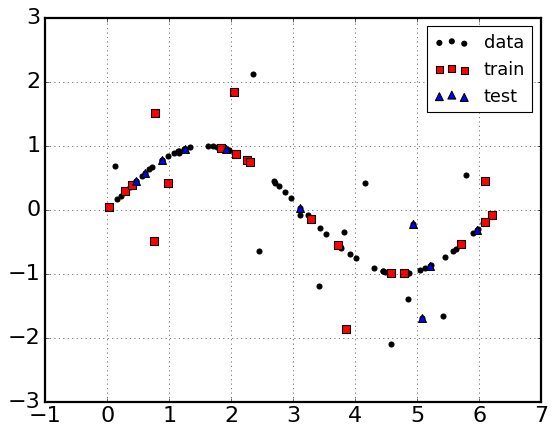

In [5]:
train_size = 20
test_size = 10

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size,
    random_state=100
)

plt.figure(figsize=(8, 6), facecolor='w')
plt.scatter(X, y, c="k", s=20, label="data", zorder=1, edgecolors=(0, 0, 0))
plt.scatter(X_train, y_train, c="r", s=40, marker="s", label="train")
plt.scatter(X_test,  y_test,  c="b", s=50, marker="^", label="test")
plt.legend()
plt.show()

## (Classical) Support Vector Regression (SVR)

Best SVR with params: {'C': 100, 'gamma': 0.07564633275546291} and R2 score: 0.196

R2  scores (train,  test): 0.698  0.818
MSE scores (train,  test): 0.229  0.122
MAE scores (train,  test): 0.099  0.070



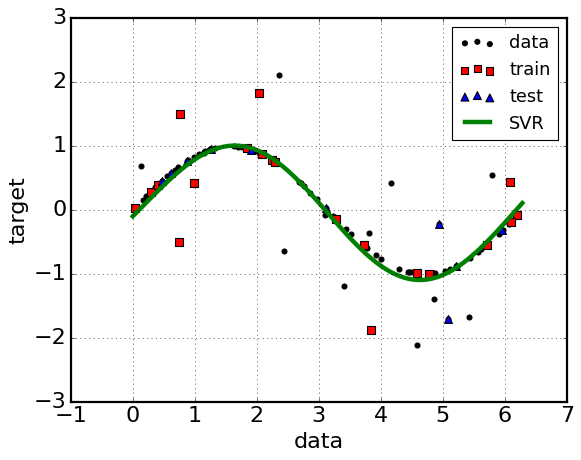

In [6]:
svr = GridSearchCV(
    SVR(kernel="rbf"),
    param_grid={"C": [1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200], "gamma": np.logspace(-2, 1, 100)},
    scoring='r2',
    n_jobs=1,
    cv=KFold(n_splits=2, shuffle=True, random_state=seed),
)
svr.fit(X_train, y_train)
print(f"Best SVR with params: {svr.best_params_} and R2 score: {svr.best_score_:.3f}")

scores(svr, X_train, y_train, X_test, y_test)
plot_model(svr)

## Randomized quantum feature maps

## 1 qubit

### QKS

   ┌──────────┐
q: ┤ Ry(θ[0]) ├
   └──────────┘

R2  scores (train,  test): 0.839  0.738
MSE scores (train,  test): 0.122  0.175
MAE scores (train,  test): 0.100  0.307

Timing info: 00h00m19s


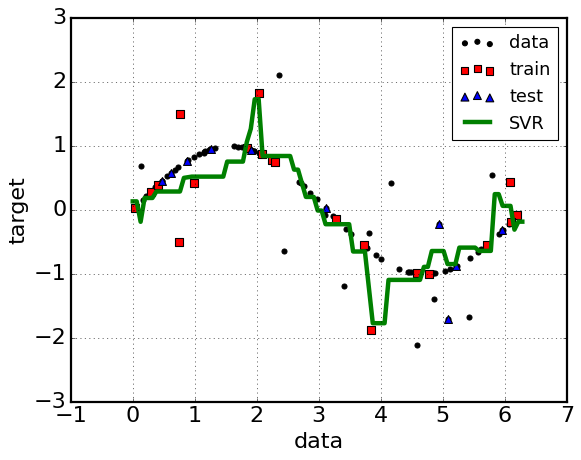

In [7]:
t0 = time.perf_counter()

n_features = len(X[0])
n_qubits = 1
n_layers = 1
n_params = n_qubits

theta = ParameterVector('θ', length=n_params)
fm = QuantumCircuit(n_qubits)

j = 0
for r in range(n_layers):
    for i in range(n_qubits):
        fm.ry(theta[j%n_features], i); j += 1
    for i in range(n_qubits-1):
        fm.cx(i, (i+1)%n_qubits)
print(fm.draw(fold=120, plot_barriers=False))

#############################################################
# QKS
#############################################################
algorithm_globals.random_seed = seed
backend = QuantumInstance(
    # Aer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed,
    Aer.get_backend("statevector_simulator"), seed_simulator=seed, seed_transpiler=seed,
)

n_episodes = 40
stddev = 0.5
qks = QuantumKitchenSinks(
    n_features, fm, 
    n_episodes=n_episodes, stddev=stddev, sampling='normal',
    backend=backend, seed=seed, 
)
emb_tr = qks.embedding(X_train)
# print('emb_tr.shape: ', emb_tr.shape)

svr = SVR(kernel='linear', C=100.0)
svr.fit(emb_tr, y_train)

scores(svr, X_train, y_train, X_test, y_test, qks=qks)
plot_model(svr, qks=qks)

t1 = time.perf_counter()
print( 'Timing info:', time.strftime("%Hh%Mm%Ss", time.gmtime(t1-t0)) )

### Projected QKS

   ┌──────────┐
q: ┤ Ry(θ[0]) ├
   └──────────┘

R2  scores (train,  test): 0.692  0.819
MSE scores (train,  test): 0.234  0.121
MAE scores (train,  test): 0.100  0.063

Timing info: 00h00m04s


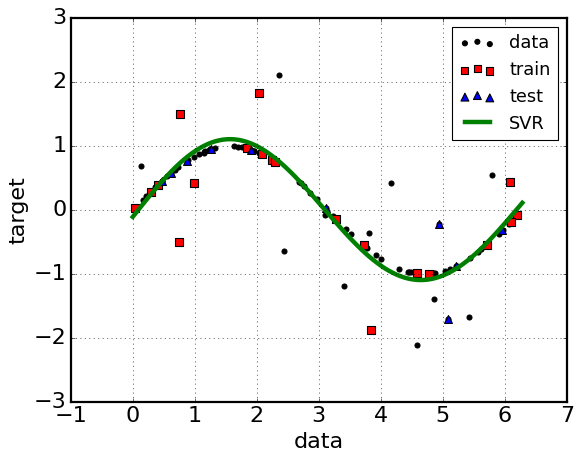

In [8]:
t0 = time.perf_counter()

n_features = len(X[0])
n_qubits = 1
n_layers = 1
n_params = n_qubits

theta = ParameterVector('θ', length=n_params)
fm = QuantumCircuit(n_qubits)

j = 0
for r in range(n_layers):
    for i in range(n_qubits):
        fm.ry(theta[j%n_features], i); j += 1
    for i in range(n_qubits-1):
        fm.cx(i, (i+1)%n_qubits)
print(fm.draw(fold=120, plot_barriers=False))

#############################################################
# QKS
#############################################################
algorithm_globals.random_seed = seed
backend = QuantumInstance(
    # Aer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed,
    Aer.get_backend("statevector_simulator"), seed_simulator=seed, seed_transpiler=seed,
)

n_episodes = 10
stddev = 0.5
qks = ProjectedQuantumKitchenSinks(
    n_features, fm, projection='z',
    n_episodes=n_episodes, stddev=stddev, sampling='normal',
    seed=seed, backend=backend, method='statevector'
)
emb_tr = qks.embedding(X_train)
# print('emb_tr.shape: ', emb_tr.shape)

svr = SVR(kernel='linear', C=100.0)
svr.fit(emb_tr, y_train)

scores(svr, X_train, y_train, X_test, y_test, qks=qks)
plot_model(svr, qks=qks)

t1 = time.perf_counter()
print( 'Timing info:', time.strftime("%Hh%Mm%Ss", time.gmtime(t1-t0)) )

## 2 qubits

### QKS

     ┌──────────┐     ┌───┐┌──────────┐     ┌───┐
q_0: ┤ Ry(θ[0]) ├──■──┤ X ├┤ Ry(θ[0]) ├──■──┤ X ├
     ├──────────┤┌─┴─┐└─┬─┘├──────────┤┌─┴─┐└─┬─┘
q_1: ┤ Ry(θ[0]) ├┤ X ├──■──┤ Ry(θ[0]) ├┤ X ├──■──
     └──────────┘└───┘     └──────────┘└───┘     

R2  scores (train,  test): 0.678  0.707
MSE scores (train,  test): 0.244  0.196
MAE scores (train,  test): 0.100  0.268

Timing info: 00h00m38s


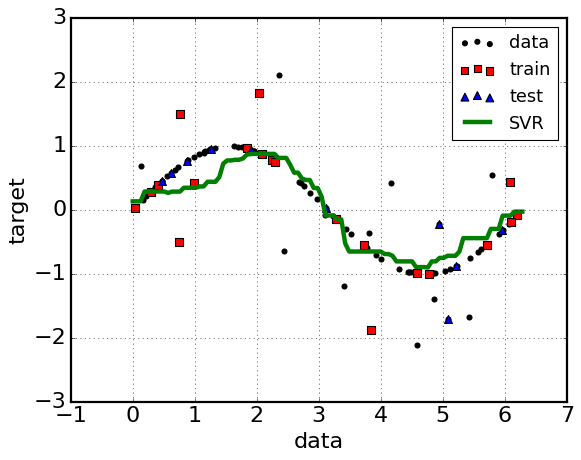

In [9]:
t0 = time.perf_counter()

n_features = len(X[0])
n_qubits = 2
n_layers = 2
n_params = n_qubits

theta = ParameterVector('θ', length=n_params)
fm = QuantumCircuit(n_qubits)

j = 0
for r in range(n_layers):
    for i in range(n_qubits):
        fm.ry(theta[j%n_features], i); j += 1
    for i in range(n_qubits):
        fm.cx(i, (i+1)%n_qubits)
print(fm.draw(fold=120, plot_barriers=False))

#############################################################
# QKS
#############################################################
algorithm_globals.random_seed = seed
backend = QuantumInstance(
    # Aer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed,
    Aer.get_backend("statevector_simulator"), seed_simulator=seed, seed_transpiler=seed,
)

n_episodes = 40
stddev = 0.5
qks = QuantumKitchenSinks(
    n_features, fm, 
    n_episodes=n_episodes, stddev=stddev, sampling='normal',
    backend=backend, seed=seed, 
)
emb_tr = qks.embedding(X_train)
# print('emb_tr.shape: ', emb_tr.shape)

svr = SVR(kernel='linear', C=100.0)
svr.fit(emb_tr, y_train)

scores(svr, X_train, y_train, X_test, y_test, qks=qks)
plot_model(svr, qks=qks)

t1 = time.perf_counter()
print( 'Timing info:', time.strftime("%Hh%Mm%Ss", time.gmtime(t1-t0)) )

### Projected QKS

     ┌──────────┐     
q_0: ┤ Ry(θ[0]) ├──■──
     ├──────────┤┌─┴─┐
q_1: ┤ Ry(θ[0]) ├┤ X ├
     └──────────┘└───┘

R2  scores (train,  test): 0.709  0.808
MSE scores (train,  test): 0.220  0.128
MAE scores (train,  test): 0.100  0.112

Timing info: 00h00m06s


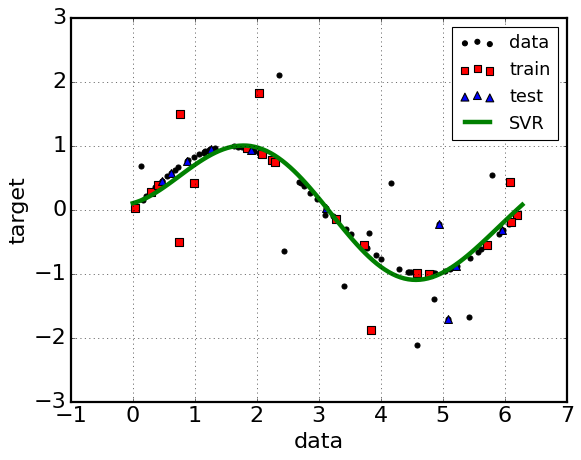

In [10]:
t0 = time.perf_counter()

n_features = len(X[0])
n_qubits = 2
n_layers = 1
n_params = n_qubits

theta = ParameterVector('θ', length=n_params)
fm = QuantumCircuit(n_qubits)

j = 0
for r in range(n_layers):
    for i in range(n_qubits):
        fm.ry(theta[j%n_features], i); j += 1
    for i in range(n_qubits-1):
        fm.cx(i, (i+1)%n_qubits)
print(fm.draw(fold=120, plot_barriers=False))

#############################################################
# QKS
#############################################################
algorithm_globals.random_seed = seed
backend = QuantumInstance(
    # Aer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed,
    Aer.get_backend("statevector_simulator"), seed_simulator=seed, seed_transpiler=seed,
)

n_episodes = 10
stddev = 0.5
qks = ProjectedQuantumKitchenSinks(
    n_features, fm, projection='z',
    n_episodes=n_episodes, stddev=stddev, sampling='normal',
    seed=seed, backend=backend, method='statevector'
)
emb_tr = qks.embedding(X_train)
# print('emb_tr.shape: ', emb_tr.shape)

svr = SVR(kernel='linear', C=100.0)
svr.fit(emb_tr, y_train)

scores(svr, X_train, y_train, X_test, y_test, qks=qks)
plot_model(svr, qks=qks)

t1 = time.perf_counter()
print( 'Timing info:', time.strftime("%Hh%Mm%Ss", time.gmtime(t1-t0)) )